<a href="https://colab.research.google.com/github/gbdionne/toneclone/blob/main/spectrogramCNN_alt9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir /content/final_datasets

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.h5" "/content/final_datasets/final_real.h5"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.csv" "/content/final_datasets/final_real.csv"

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/test_extra_TRM_DLY.h5" "/content/final_datasets/test_extra_TRM_DLY.h5"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/test_extra_TRM_DLY.csv" "/content/final_datasets/test_extra_TRM_DLY.csv"

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/validate_extra_TRM_DLY.h5" "/content/final_datasets/validate_extra_TRM_DLY.h5"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/validate_extra_TRM_DLY.csv" "/content/final_datasets/validate_extra_TRM_DLY.csv"

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/train_extra_TRM_DLY.h5" "/content/final_datasets/train_extra_TRM_DLY.h5"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/train_extra_TRM_DLY.csv" "/content/final_datasets/train_extra_TRM_DLY.csv"

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import h5py
import pandas as pd
from sklearn.metrics import classification_report
import torchaudio.transforms as T
import random
import warnings

warnings.filterwarnings("ignore", message="Downcasting object dtype arrays on .fillna")

class SpectrogramDataset(Dataset):
    """
    Custom dataset for spectrogram data with data augmentation.
    Includes:
    - Random Gaussian noise
    - Pitch shifting using torch.roll() with zero-padding (prevents wrapping)
    """

    def __init__(self, hdf5_file, csv_file, augment=True, noise_level=0.03, pitch_shift_range=(-0.5, 0.5)):
        """
        Args:
            hdf5_file (str): Path to the HDF5 file containing spectrograms.
            csv_file (str): Path to CSV file with labels.
            augment (bool): Whether to apply data augmentation.
            noise_level (float): Standard deviation of Gaussian noise to add.
            pitch_shift_range (tuple): Min/max semitones for pitch shifting.
        """
        self.hdf5_file_path = hdf5_file
        self.labels = pd.read_csv(csv_file)

        # Manually define only important columns
        self.label_map = [
            'overdrive', 'distortion', 'fuzz', 'tremolo', 'phaser',
            'flanger', 'chorus', 'delay', 'hall_reverb', 'plate_reverb',
            'octaver', 'auto_filter'
        ]

        # Drop all non-label columns
        self.labels = self.labels[['key'] + self.label_map]

        self.hdf5_file = None  # Open HDF5 file once per worker

        self.augment = augment
        self.noise_level = noise_level
        self.pitch_shift_range = pitch_shift_range

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Open HDF5 file per worker to avoid threading issues
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_file_path, "r", swmr=True)

        # Retrieve spectrogram
        key = self.labels.iloc[idx]['key']
        spectrogram = torch.tensor(self.hdf5_file[key][()], dtype=torch.float32).unsqueeze(0)

        # Retrieve labels
        label_values = self.labels.iloc[idx][1:].fillna(0).astype(float).values
        label = torch.tensor(label_values, dtype=torch.float32)

        # Data augmentation
        if self.augment:
            spectrogram = self.add_noise(spectrogram)
            spectrogram = self.pitch_shift(spectrogram)

        return spectrogram, label

    def add_noise(self, spectrogram):
        """Adds Gaussian noise where noise level is randomly chosen between 0 and self.noise_level."""
        noise_level = random.uniform(0, self.noise_level)  # Random noise per sample
        noise = torch.randn_like(spectrogram) * noise_level  # Scale noise
        return spectrogram + noise

    def pitch_shift(self, spectrogram):
        """Shifts spectrogram frequency bins using torch.roll() with zero padding."""
        semitone_shift = random.uniform(*self.pitch_shift_range)  # Random shift between min/max
        shift_bins = int(semitone_shift / 12 * spectrogram.shape[-2])  # Convert semitone shift to frequency bins

        # Apply frequency bin shift using torch.roll() with zero-padding
        shifted = torch.roll(spectrogram, shifts=shift_bins, dims=-2)  # Shift along frequency axis

        if shift_bins > 0:  # Shift up (higher pitch)
            shifted[..., :shift_bins, :] = 0  # Zero-pad low frequencies
        elif shift_bins < 0:  # Shift down (lower pitch)
            shifted[..., shift_bins:, :] = 0  # Zero-pad high frequencies

        return shifted

    def __del__(self):
        if self.hdf5_file is not None:
            self.hdf5_file.close()

In [4]:
class spectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(spectrogramCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # Max pooling

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Dropout
        x = self.fc2(x)
        return x

In [5]:
# Initialize dataset from HD5F and csv file

h5_train_path = '/content/final_datasets/train_extra_TRM_DLY.h5'
csv_train_path = '/content/final_datasets/train_extra_TRM_DLY.csv'

h5_val_path = '/content/final_datasets/validate_extra_TRM_DLY.h5'
csv_val_path = '/content/final_datasets/validate_extra_TRM_DLY.csv'

model_save_path = "/content/drive/MyDrive/Capstone 210/Models/final_multi_effects_alt9.mod"

train_dataset = SpectrogramDataset(h5_train_path, csv_train_path)
val_dataset = SpectrogramDataset(h5_val_path, csv_val_path)

In [6]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=6, pin_memory=True)

num_classes = len(train_dataset.label_map)

model = spectrogramCNN(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8681)  # 0.0001 → 0.000005 over 25 epochs
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

train_losses = []
val_losses = []

# Training loop
num_epochs = 25
print_freq = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (spectrograms, labels) in enumerate(train_loader):
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Update learning rate
    scheduler.step()
    print(f"Updated Learning Rate: {scheduler.get_last_lr()}")

    # Validation step
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for spectrograms, labels in val_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions

            # Store for metric computation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Convert lists to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    # Print classification report
    class_names = train_dataset.label_map
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print(f"\nValidation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")

    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

Epoch [1/25], Batch [100/4502], Loss: 0.2853
Epoch [1/25], Batch [200/4502], Loss: 0.2481
Epoch [1/25], Batch [300/4502], Loss: 0.1728
Epoch [1/25], Batch [400/4502], Loss: 0.1511
Epoch [1/25], Batch [500/4502], Loss: 0.1333
Epoch [1/25], Batch [600/4502], Loss: 0.1355
Epoch [1/25], Batch [700/4502], Loss: 0.1112
Epoch [1/25], Batch [800/4502], Loss: 0.1123
Epoch [1/25], Batch [900/4502], Loss: 0.0947
Epoch [1/25], Batch [1000/4502], Loss: 0.0733
Epoch [1/25], Batch [1100/4502], Loss: 0.0978
Epoch [1/25], Batch [1200/4502], Loss: 0.0783
Epoch [1/25], Batch [1300/4502], Loss: 0.1070
Epoch [1/25], Batch [1400/4502], Loss: 0.0775
Epoch [1/25], Batch [1500/4502], Loss: 0.0689
Epoch [1/25], Batch [1600/4502], Loss: 0.0731
Epoch [1/25], Batch [1700/4502], Loss: 0.0833
Epoch [1/25], Batch [1800/4502], Loss: 0.0465
Epoch [1/25], Batch [1900/4502], Loss: 0.0411
Epoch [1/25], Batch [2000/4502], Loss: 0.0399
Epoch [1/25], Batch [2100/4502], Loss: 0.0342
Epoch [1/25], Batch [2200/4502], Loss: 0.03

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   overdrive       0.99      0.96      0.98      3012
  distortion       1.00      0.89      0.94      4518
        fuzz       0.94      1.00      0.97      5271
     tremolo       1.00      0.97      0.99      5671
      phaser       1.00      0.98      0.99      4518
     flanger       0.99      0.90      0.95      3012
      chorus       1.00      1.00      1.00      5671
       delay       0.40      1.00      0.57      7530
 hall_reverb       0.95      0.80      0.87      4518
plate_reverb       0.97      0.84      0.90      3012
     octaver       0.95      0.99      0.97      2259
 auto_filter       1.00      0.98      0.99      3765

   micro avg       0.80      0.95      0.87     52757
   macro avg       0.93      0.94      0.92     52757
weighted avg       0.90      0.95      0.90     52757
 samples avg       0.80      0.92      0.84     52757


Validation Loss: 0.1243, Accuracy: 0.5664, Precision: 0.9319, Recall: 0.9424, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/25], Batch [100/4502], Loss: 0.0146
Epoch [3/25], Batch [200/4502], Loss: 0.0058
Epoch [3/25], Batch [300/4502], Loss: 0.0116
Epoch [3/25], Batch [400/4502], Loss: 0.0190
Epoch [3/25], Batch [500/4502], Loss: 0.0220
Epoch [3/25], Batch [600/4502], Loss: 0.0172
Epoch [3/25], Batch [700/4502], Loss: 0.0151
Epoch [3/25], Batch [800/4502], Loss: 0.0508
Epoch [3/25], Batch [900/4502], Loss: 0.0055
Epoch [3/25], Batch [1000/4502], Loss: 0.0117
Epoch [3/25], Batch [1100/4502], Loss: 0.0085
Epoch [3/25], Batch [1200/4502], Loss: 0.0177
Epoch [3/25], Batch [1300/4502], Loss: 0.0030
Epoch [3/25], Batch [1400/4502], Loss: 0.0041
Epoch [3/25], Batch [1500/4502], Loss: 0.0212
Epoch [3/25], Batch [1600/4502], Loss: 0.0071
Epoch [3/25], Batch [1700/4502], Loss: 0.0165
Epoch [3/25], Batch [1800/4502], Loss: 0.0067
Epoch [3/25], Batch [1900/4502], Loss: 0.0086
Epoch [3/25], Batch [2000/4502], Loss: 0.0031
Epoch [3/25], Batch [2100/4502], Loss: 0.0054
Epoch [3/25], Batch [2200/4502], Loss: 0.01

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/25], Batch [100/4502], Loss: 0.0031
Epoch [4/25], Batch [200/4502], Loss: 0.0111
Epoch [4/25], Batch [300/4502], Loss: 0.0066
Epoch [4/25], Batch [400/4502], Loss: 0.0062
Epoch [4/25], Batch [500/4502], Loss: 0.0174
Epoch [4/25], Batch [600/4502], Loss: 0.0209
Epoch [4/25], Batch [700/4502], Loss: 0.0064
Epoch [4/25], Batch [800/4502], Loss: 0.0061
Epoch [4/25], Batch [900/4502], Loss: 0.0035
Epoch [4/25], Batch [1000/4502], Loss: 0.0140
Epoch [4/25], Batch [1100/4502], Loss: 0.0268
Epoch [4/25], Batch [1200/4502], Loss: 0.0030
Epoch [4/25], Batch [1300/4502], Loss: 0.0031
Epoch [4/25], Batch [1400/4502], Loss: 0.0050
Epoch [4/25], Batch [1500/4502], Loss: 0.0052
Epoch [4/25], Batch [1600/4502], Loss: 0.0090
Epoch [4/25], Batch [1700/4502], Loss: 0.0177
Epoch [4/25], Batch [1800/4502], Loss: 0.0028
Epoch [4/25], Batch [1900/4502], Loss: 0.0196
Epoch [4/25], Batch [2000/4502], Loss: 0.0092
Epoch [4/25], Batch [2100/4502], Loss: 0.0088
Epoch [4/25], Batch [2200/4502], Loss: 0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/25], Batch [100/4502], Loss: 0.0026
Epoch [5/25], Batch [200/4502], Loss: 0.0163
Epoch [5/25], Batch [300/4502], Loss: 0.0013
Epoch [5/25], Batch [400/4502], Loss: 0.0046
Epoch [5/25], Batch [500/4502], Loss: 0.0090
Epoch [5/25], Batch [600/4502], Loss: 0.0101
Epoch [5/25], Batch [700/4502], Loss: 0.0011
Epoch [5/25], Batch [800/4502], Loss: 0.0031
Epoch [5/25], Batch [900/4502], Loss: 0.0060
Epoch [5/25], Batch [1000/4502], Loss: 0.0054
Epoch [5/25], Batch [1100/4502], Loss: 0.0176
Epoch [5/25], Batch [1200/4502], Loss: 0.0011
Epoch [5/25], Batch [1300/4502], Loss: 0.0127
Epoch [5/25], Batch [1400/4502], Loss: 0.0026
Epoch [5/25], Batch [1500/4502], Loss: 0.0172
Epoch [5/25], Batch [1600/4502], Loss: 0.0032
Epoch [5/25], Batch [1700/4502], Loss: 0.0015
Epoch [5/25], Batch [1800/4502], Loss: 0.0102
Epoch [5/25], Batch [1900/4502], Loss: 0.0032
Epoch [5/25], Batch [2000/4502], Loss: 0.0006
Epoch [5/25], Batch [2100/4502], Loss: 0.0153
Epoch [5/25], Batch [2200/4502], Loss: 0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/25], Batch [100/4502], Loss: 0.0309
Epoch [6/25], Batch [200/4502], Loss: 0.0176
Epoch [6/25], Batch [300/4502], Loss: 0.0045
Epoch [6/25], Batch [400/4502], Loss: 0.0029
Epoch [6/25], Batch [500/4502], Loss: 0.0038
Epoch [6/25], Batch [600/4502], Loss: 0.0059
Epoch [6/25], Batch [700/4502], Loss: 0.0210
Epoch [6/25], Batch [800/4502], Loss: 0.0011
Epoch [6/25], Batch [900/4502], Loss: 0.0010
Epoch [6/25], Batch [1000/4502], Loss: 0.0097
Epoch [6/25], Batch [1100/4502], Loss: 0.0022
Epoch [6/25], Batch [1200/4502], Loss: 0.0189
Epoch [6/25], Batch [1300/4502], Loss: 0.0051
Epoch [6/25], Batch [1400/4502], Loss: 0.0029
Epoch [6/25], Batch [1500/4502], Loss: 0.0058
Epoch [6/25], Batch [1600/4502], Loss: 0.0205
Epoch [6/25], Batch [1700/4502], Loss: 0.0029
Epoch [6/25], Batch [1800/4502], Loss: 0.0063
Epoch [6/25], Batch [1900/4502], Loss: 0.0037
Epoch [6/25], Batch [2000/4502], Loss: 0.0035
Epoch [6/25], Batch [2100/4502], Loss: 0.0009
Epoch [6/25], Batch [2200/4502], Loss: 0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/25], Batch [100/4502], Loss: 0.0075
Epoch [7/25], Batch [200/4502], Loss: 0.0052
Epoch [7/25], Batch [300/4502], Loss: 0.0079
Epoch [7/25], Batch [400/4502], Loss: 0.0009
Epoch [7/25], Batch [500/4502], Loss: 0.0009
Epoch [7/25], Batch [600/4502], Loss: 0.0161
Epoch [7/25], Batch [700/4502], Loss: 0.0046
Epoch [7/25], Batch [800/4502], Loss: 0.0018
Epoch [7/25], Batch [900/4502], Loss: 0.0211
Epoch [7/25], Batch [1000/4502], Loss: 0.0009
Epoch [7/25], Batch [1100/4502], Loss: 0.0007
Epoch [7/25], Batch [1200/4502], Loss: 0.0096
Epoch [7/25], Batch [1300/4502], Loss: 0.0049
Epoch [7/25], Batch [1400/4502], Loss: 0.0055
Epoch [7/25], Batch [1500/4502], Loss: 0.0008
Epoch [7/25], Batch [1600/4502], Loss: 0.0010
Epoch [7/25], Batch [1700/4502], Loss: 0.0113
Epoch [7/25], Batch [1800/4502], Loss: 0.0202
Epoch [7/25], Batch [1900/4502], Loss: 0.0055
Epoch [7/25], Batch [2000/4502], Loss: 0.0052
Epoch [7/25], Batch [2100/4502], Loss: 0.0020
Epoch [7/25], Batch [2200/4502], Loss: 0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/25], Batch [100/4502], Loss: 0.0140
Epoch [8/25], Batch [200/4502], Loss: 0.0216
Epoch [8/25], Batch [300/4502], Loss: 0.0102
Epoch [8/25], Batch [400/4502], Loss: 0.0057
Epoch [8/25], Batch [500/4502], Loss: 0.0010
Epoch [8/25], Batch [600/4502], Loss: 0.0070
Epoch [8/25], Batch [700/4502], Loss: 0.0003
Epoch [8/25], Batch [800/4502], Loss: 0.0134
Epoch [8/25], Batch [900/4502], Loss: 0.0007
Epoch [8/25], Batch [1000/4502], Loss: 0.0152
Epoch [8/25], Batch [1100/4502], Loss: 0.0033
Epoch [8/25], Batch [1200/4502], Loss: 0.0003
Epoch [8/25], Batch [1300/4502], Loss: 0.0055
Epoch [8/25], Batch [1400/4502], Loss: 0.0021
Epoch [8/25], Batch [1500/4502], Loss: 0.0017
Epoch [8/25], Batch [1600/4502], Loss: 0.0009
Epoch [8/25], Batch [1700/4502], Loss: 0.0048
Epoch [8/25], Batch [1800/4502], Loss: 0.0008
Epoch [8/25], Batch [1900/4502], Loss: 0.0048
Epoch [8/25], Batch [2000/4502], Loss: 0.0013
Epoch [8/25], Batch [2100/4502], Loss: 0.0160
Epoch [8/25], Batch [2200/4502], Loss: 0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/25], Batch [100/4502], Loss: 0.0029
Epoch [9/25], Batch [200/4502], Loss: 0.0010
Epoch [9/25], Batch [300/4502], Loss: 0.0014
Epoch [9/25], Batch [400/4502], Loss: 0.0012
Epoch [9/25], Batch [500/4502], Loss: 0.0023
Epoch [9/25], Batch [600/4502], Loss: 0.0006
Epoch [9/25], Batch [700/4502], Loss: 0.0079
Epoch [9/25], Batch [800/4502], Loss: 0.0115
Epoch [9/25], Batch [900/4502], Loss: 0.0008
Epoch [9/25], Batch [1000/4502], Loss: 0.0106
Epoch [9/25], Batch [1100/4502], Loss: 0.0002
Epoch [9/25], Batch [1200/4502], Loss: 0.0101
Epoch [9/25], Batch [1300/4502], Loss: 0.0003
Epoch [9/25], Batch [1400/4502], Loss: 0.0027
Epoch [9/25], Batch [1500/4502], Loss: 0.0021
Epoch [9/25], Batch [1600/4502], Loss: 0.0002
Epoch [9/25], Batch [1700/4502], Loss: 0.0017
Epoch [9/25], Batch [1800/4502], Loss: 0.0009
Epoch [9/25], Batch [1900/4502], Loss: 0.0060
Epoch [9/25], Batch [2000/4502], Loss: 0.0020
Epoch [9/25], Batch [2100/4502], Loss: 0.0020
Epoch [9/25], Batch [2200/4502], Loss: 0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/25], Batch [100/4502], Loss: 0.0007
Epoch [10/25], Batch [200/4502], Loss: 0.0064
Epoch [10/25], Batch [300/4502], Loss: 0.0069
Epoch [10/25], Batch [400/4502], Loss: 0.0002
Epoch [10/25], Batch [500/4502], Loss: 0.0020
Epoch [10/25], Batch [600/4502], Loss: 0.0004
Epoch [10/25], Batch [700/4502], Loss: 0.0117
Epoch [10/25], Batch [800/4502], Loss: 0.0009
Epoch [10/25], Batch [900/4502], Loss: 0.0133
Epoch [10/25], Batch [1000/4502], Loss: 0.0034
Epoch [10/25], Batch [1100/4502], Loss: 0.0006
Epoch [10/25], Batch [1200/4502], Loss: 0.0052
Epoch [10/25], Batch [1300/4502], Loss: 0.0009
Epoch [10/25], Batch [1400/4502], Loss: 0.0012
Epoch [10/25], Batch [1500/4502], Loss: 0.0109
Epoch [10/25], Batch [1600/4502], Loss: 0.0002
Epoch [10/25], Batch [1700/4502], Loss: 0.0006
Epoch [10/25], Batch [1800/4502], Loss: 0.0041
Epoch [10/25], Batch [1900/4502], Loss: 0.0151
Epoch [10/25], Batch [2000/4502], Loss: 0.0058
Epoch [10/25], Batch [2100/4502], Loss: 0.0016
Epoch [10/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/25], Batch [100/4502], Loss: 0.0080
Epoch [11/25], Batch [200/4502], Loss: 0.0169
Epoch [11/25], Batch [300/4502], Loss: 0.0003
Epoch [11/25], Batch [400/4502], Loss: 0.0196
Epoch [11/25], Batch [500/4502], Loss: 0.0008
Epoch [11/25], Batch [600/4502], Loss: 0.0018
Epoch [11/25], Batch [700/4502], Loss: 0.0003
Epoch [11/25], Batch [800/4502], Loss: 0.0014
Epoch [11/25], Batch [900/4502], Loss: 0.0076
Epoch [11/25], Batch [1000/4502], Loss: 0.0130
Epoch [11/25], Batch [1100/4502], Loss: 0.0005
Epoch [11/25], Batch [1200/4502], Loss: 0.0012
Epoch [11/25], Batch [1300/4502], Loss: 0.0028
Epoch [11/25], Batch [1400/4502], Loss: 0.0003
Epoch [11/25], Batch [1500/4502], Loss: 0.0004
Epoch [11/25], Batch [1600/4502], Loss: 0.0025
Epoch [11/25], Batch [1700/4502], Loss: 0.0006
Epoch [11/25], Batch [1800/4502], Loss: 0.0019
Epoch [11/25], Batch [1900/4502], Loss: 0.0002
Epoch [11/25], Batch [2000/4502], Loss: 0.0010
Epoch [11/25], Batch [2100/4502], Loss: 0.0046
Epoch [11/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/25], Batch [100/4502], Loss: 0.0026
Epoch [12/25], Batch [200/4502], Loss: 0.0025
Epoch [12/25], Batch [300/4502], Loss: 0.0007
Epoch [12/25], Batch [400/4502], Loss: 0.0017
Epoch [12/25], Batch [500/4502], Loss: 0.0009
Epoch [12/25], Batch [600/4502], Loss: 0.0007
Epoch [12/25], Batch [700/4502], Loss: 0.0090
Epoch [12/25], Batch [800/4502], Loss: 0.0037
Epoch [12/25], Batch [900/4502], Loss: 0.0002
Epoch [12/25], Batch [1000/4502], Loss: 0.0002
Epoch [12/25], Batch [1100/4502], Loss: 0.0004
Epoch [12/25], Batch [1200/4502], Loss: 0.0111
Epoch [12/25], Batch [1300/4502], Loss: 0.0005
Epoch [12/25], Batch [1400/4502], Loss: 0.0011
Epoch [12/25], Batch [1500/4502], Loss: 0.0001
Epoch [12/25], Batch [1600/4502], Loss: 0.0014
Epoch [12/25], Batch [1700/4502], Loss: 0.0021
Epoch [12/25], Batch [1800/4502], Loss: 0.0011
Epoch [12/25], Batch [1900/4502], Loss: 0.0049
Epoch [12/25], Batch [2000/4502], Loss: 0.0039
Epoch [12/25], Batch [2100/4502], Loss: 0.0008
Epoch [12/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/25], Batch [100/4502], Loss: 0.0006
Epoch [13/25], Batch [200/4502], Loss: 0.0004
Epoch [13/25], Batch [300/4502], Loss: 0.0028
Epoch [13/25], Batch [400/4502], Loss: 0.0150
Epoch [13/25], Batch [500/4502], Loss: 0.0002
Epoch [13/25], Batch [600/4502], Loss: 0.0010
Epoch [13/25], Batch [700/4502], Loss: 0.0006
Epoch [13/25], Batch [800/4502], Loss: 0.0007
Epoch [13/25], Batch [900/4502], Loss: 0.0005
Epoch [13/25], Batch [1000/4502], Loss: 0.0021
Epoch [13/25], Batch [1100/4502], Loss: 0.0123
Epoch [13/25], Batch [1200/4502], Loss: 0.0049
Epoch [13/25], Batch [1300/4502], Loss: 0.0027
Epoch [13/25], Batch [1400/4502], Loss: 0.0049
Epoch [13/25], Batch [1500/4502], Loss: 0.0003
Epoch [13/25], Batch [1600/4502], Loss: 0.0017
Epoch [13/25], Batch [1700/4502], Loss: 0.0012
Epoch [13/25], Batch [1800/4502], Loss: 0.0004
Epoch [13/25], Batch [1900/4502], Loss: 0.0002
Epoch [13/25], Batch [2000/4502], Loss: 0.0090
Epoch [13/25], Batch [2100/4502], Loss: 0.0009
Epoch [13/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/25], Batch [100/4502], Loss: 0.0006
Epoch [14/25], Batch [200/4502], Loss: 0.0028
Epoch [14/25], Batch [300/4502], Loss: 0.0218
Epoch [14/25], Batch [400/4502], Loss: 0.0019
Epoch [14/25], Batch [500/4502], Loss: 0.0059
Epoch [14/25], Batch [600/4502], Loss: 0.0035
Epoch [14/25], Batch [700/4502], Loss: 0.0022
Epoch [14/25], Batch [800/4502], Loss: 0.0015
Epoch [14/25], Batch [900/4502], Loss: 0.0003
Epoch [14/25], Batch [1000/4502], Loss: 0.0006
Epoch [14/25], Batch [1100/4502], Loss: 0.0130
Epoch [14/25], Batch [1200/4502], Loss: 0.0017
Epoch [14/25], Batch [1300/4502], Loss: 0.0154
Epoch [14/25], Batch [1400/4502], Loss: 0.0003
Epoch [14/25], Batch [1500/4502], Loss: 0.0003
Epoch [14/25], Batch [1600/4502], Loss: 0.0004
Epoch [14/25], Batch [1700/4502], Loss: 0.0005
Epoch [14/25], Batch [1800/4502], Loss: 0.0018
Epoch [14/25], Batch [1900/4502], Loss: 0.0022
Epoch [14/25], Batch [2000/4502], Loss: 0.0048
Epoch [14/25], Batch [2100/4502], Loss: 0.0027
Epoch [14/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [15/25], Batch [100/4502], Loss: 0.0001
Epoch [15/25], Batch [200/4502], Loss: 0.0005
Epoch [15/25], Batch [300/4502], Loss: 0.0001
Epoch [15/25], Batch [400/4502], Loss: 0.0062
Epoch [15/25], Batch [500/4502], Loss: 0.0009
Epoch [15/25], Batch [600/4502], Loss: 0.0011
Epoch [15/25], Batch [700/4502], Loss: 0.0010
Epoch [15/25], Batch [800/4502], Loss: 0.0001
Epoch [15/25], Batch [900/4502], Loss: 0.0002
Epoch [15/25], Batch [1000/4502], Loss: 0.0013
Epoch [15/25], Batch [1100/4502], Loss: 0.0088
Epoch [15/25], Batch [1200/4502], Loss: 0.0103
Epoch [15/25], Batch [1300/4502], Loss: 0.0002
Epoch [15/25], Batch [1400/4502], Loss: 0.0004
Epoch [15/25], Batch [1500/4502], Loss: 0.0001
Epoch [15/25], Batch [1600/4502], Loss: 0.0002
Epoch [15/25], Batch [1700/4502], Loss: 0.0007
Epoch [15/25], Batch [1800/4502], Loss: 0.0005
Epoch [15/25], Batch [1900/4502], Loss: 0.0002
Epoch [15/25], Batch [2000/4502], Loss: 0.0011
Epoch [15/25], Batch [2100/4502], Loss: 0.0001
Epoch [15/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [16/25], Batch [100/4502], Loss: 0.0020
Epoch [16/25], Batch [200/4502], Loss: 0.0014
Epoch [16/25], Batch [300/4502], Loss: 0.0002
Epoch [16/25], Batch [400/4502], Loss: 0.0002
Epoch [16/25], Batch [500/4502], Loss: 0.0002
Epoch [16/25], Batch [600/4502], Loss: 0.0011
Epoch [16/25], Batch [700/4502], Loss: 0.0009
Epoch [16/25], Batch [800/4502], Loss: 0.0000
Epoch [16/25], Batch [900/4502], Loss: 0.0001
Epoch [16/25], Batch [1000/4502], Loss: 0.0003
Epoch [16/25], Batch [1100/4502], Loss: 0.0003
Epoch [16/25], Batch [1200/4502], Loss: 0.0012
Epoch [16/25], Batch [1300/4502], Loss: 0.0005
Epoch [16/25], Batch [1400/4502], Loss: 0.0035
Epoch [16/25], Batch [1500/4502], Loss: 0.0008
Epoch [16/25], Batch [1600/4502], Loss: 0.0002
Epoch [16/25], Batch [1700/4502], Loss: 0.0006
Epoch [16/25], Batch [1800/4502], Loss: 0.0011
Epoch [16/25], Batch [1900/4502], Loss: 0.0003
Epoch [16/25], Batch [2000/4502], Loss: 0.0003
Epoch [16/25], Batch [2100/4502], Loss: 0.0013
Epoch [16/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [17/25], Batch [100/4502], Loss: 0.0001
Epoch [17/25], Batch [200/4502], Loss: 0.0005
Epoch [17/25], Batch [300/4502], Loss: 0.0010
Epoch [17/25], Batch [400/4502], Loss: 0.0007
Epoch [17/25], Batch [500/4502], Loss: 0.0000
Epoch [17/25], Batch [600/4502], Loss: 0.0002
Epoch [17/25], Batch [700/4502], Loss: 0.0023
Epoch [17/25], Batch [800/4502], Loss: 0.0003
Epoch [17/25], Batch [900/4502], Loss: 0.0001
Epoch [17/25], Batch [1000/4502], Loss: 0.0003
Epoch [17/25], Batch [1100/4502], Loss: 0.0001
Epoch [17/25], Batch [1200/4502], Loss: 0.0007
Epoch [17/25], Batch [1300/4502], Loss: 0.0011
Epoch [17/25], Batch [1400/4502], Loss: 0.0000
Epoch [17/25], Batch [1500/4502], Loss: 0.0085
Epoch [17/25], Batch [1600/4502], Loss: 0.0039
Epoch [17/25], Batch [1700/4502], Loss: 0.0000
Epoch [17/25], Batch [1800/4502], Loss: 0.0105
Epoch [17/25], Batch [1900/4502], Loss: 0.0057
Epoch [17/25], Batch [2000/4502], Loss: 0.0082
Epoch [17/25], Batch [2100/4502], Loss: 0.0002
Epoch [17/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [18/25], Batch [100/4502], Loss: 0.0016
Epoch [18/25], Batch [200/4502], Loss: 0.0003
Epoch [18/25], Batch [300/4502], Loss: 0.0047
Epoch [18/25], Batch [400/4502], Loss: 0.0009
Epoch [18/25], Batch [500/4502], Loss: 0.0034
Epoch [18/25], Batch [600/4502], Loss: 0.0001
Epoch [18/25], Batch [700/4502], Loss: 0.0098
Epoch [18/25], Batch [800/4502], Loss: 0.0001
Epoch [18/25], Batch [900/4502], Loss: 0.0009
Epoch [18/25], Batch [1000/4502], Loss: 0.0010
Epoch [18/25], Batch [1100/4502], Loss: 0.0001
Epoch [18/25], Batch [1200/4502], Loss: 0.0032
Epoch [18/25], Batch [1300/4502], Loss: 0.0010
Epoch [18/25], Batch [1400/4502], Loss: 0.0002
Epoch [18/25], Batch [1500/4502], Loss: 0.0035
Epoch [18/25], Batch [1600/4502], Loss: 0.0013
Epoch [18/25], Batch [1700/4502], Loss: 0.0049
Epoch [18/25], Batch [1800/4502], Loss: 0.0048
Epoch [18/25], Batch [1900/4502], Loss: 0.0000
Epoch [18/25], Batch [2000/4502], Loss: 0.0020
Epoch [18/25], Batch [2100/4502], Loss: 0.0031
Epoch [18/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/25], Batch [100/4502], Loss: 0.0017
Epoch [19/25], Batch [200/4502], Loss: 0.0002
Epoch [19/25], Batch [300/4502], Loss: 0.0044
Epoch [19/25], Batch [400/4502], Loss: 0.0001
Epoch [19/25], Batch [500/4502], Loss: 0.0005
Epoch [19/25], Batch [600/4502], Loss: 0.0010
Epoch [19/25], Batch [700/4502], Loss: 0.0002
Epoch [19/25], Batch [800/4502], Loss: 0.0006
Epoch [19/25], Batch [900/4502], Loss: 0.0002
Epoch [19/25], Batch [1000/4502], Loss: 0.0002
Epoch [19/25], Batch [1100/4502], Loss: 0.0058
Epoch [19/25], Batch [1200/4502], Loss: 0.0010
Epoch [19/25], Batch [1300/4502], Loss: 0.0020
Epoch [19/25], Batch [1400/4502], Loss: 0.0001
Epoch [19/25], Batch [1500/4502], Loss: 0.0022
Epoch [19/25], Batch [1600/4502], Loss: 0.0012
Epoch [19/25], Batch [1700/4502], Loss: 0.0004
Epoch [19/25], Batch [1800/4502], Loss: 0.0040
Epoch [19/25], Batch [1900/4502], Loss: 0.0110
Epoch [19/25], Batch [2000/4502], Loss: 0.0007
Epoch [19/25], Batch [2100/4502], Loss: 0.0002
Epoch [19/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/25], Batch [100/4502], Loss: 0.0003
Epoch [20/25], Batch [200/4502], Loss: 0.0001
Epoch [20/25], Batch [300/4502], Loss: 0.0003
Epoch [20/25], Batch [400/4502], Loss: 0.0003
Epoch [20/25], Batch [500/4502], Loss: 0.0016
Epoch [20/25], Batch [600/4502], Loss: 0.0002
Epoch [20/25], Batch [700/4502], Loss: 0.0078
Epoch [20/25], Batch [800/4502], Loss: 0.0000
Epoch [20/25], Batch [900/4502], Loss: 0.0001
Epoch [20/25], Batch [1000/4502], Loss: 0.0001
Epoch [20/25], Batch [1100/4502], Loss: 0.0006
Epoch [20/25], Batch [1200/4502], Loss: 0.0002
Epoch [20/25], Batch [1300/4502], Loss: 0.0264
Epoch [20/25], Batch [1400/4502], Loss: 0.0000
Epoch [20/25], Batch [1500/4502], Loss: 0.0002
Epoch [20/25], Batch [1600/4502], Loss: 0.0012
Epoch [20/25], Batch [1700/4502], Loss: 0.0002
Epoch [20/25], Batch [1800/4502], Loss: 0.0036
Epoch [20/25], Batch [1900/4502], Loss: 0.0022
Epoch [20/25], Batch [2000/4502], Loss: 0.0012
Epoch [20/25], Batch [2100/4502], Loss: 0.0149
Epoch [20/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [21/25], Batch [100/4502], Loss: 0.0165
Epoch [21/25], Batch [200/4502], Loss: 0.0002
Epoch [21/25], Batch [300/4502], Loss: 0.0001
Epoch [21/25], Batch [400/4502], Loss: 0.0011
Epoch [21/25], Batch [500/4502], Loss: 0.0000
Epoch [21/25], Batch [600/4502], Loss: 0.0023
Epoch [21/25], Batch [700/4502], Loss: 0.0036
Epoch [21/25], Batch [800/4502], Loss: 0.0001
Epoch [21/25], Batch [900/4502], Loss: 0.0000
Epoch [21/25], Batch [1000/4502], Loss: 0.0004
Epoch [21/25], Batch [1100/4502], Loss: 0.0024
Epoch [21/25], Batch [1200/4502], Loss: 0.0016
Epoch [21/25], Batch [1300/4502], Loss: 0.0001
Epoch [21/25], Batch [1400/4502], Loss: 0.0047
Epoch [21/25], Batch [1500/4502], Loss: 0.0000
Epoch [21/25], Batch [1600/4502], Loss: 0.0000
Epoch [21/25], Batch [1700/4502], Loss: 0.0057
Epoch [21/25], Batch [1800/4502], Loss: 0.0011
Epoch [21/25], Batch [1900/4502], Loss: 0.0086
Epoch [21/25], Batch [2000/4502], Loss: 0.0041
Epoch [21/25], Batch [2100/4502], Loss: 0.0050
Epoch [21/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [22/25], Batch [100/4502], Loss: 0.0005
Epoch [22/25], Batch [200/4502], Loss: 0.0011
Epoch [22/25], Batch [300/4502], Loss: 0.0002
Epoch [22/25], Batch [400/4502], Loss: 0.0028
Epoch [22/25], Batch [500/4502], Loss: 0.0004
Epoch [22/25], Batch [600/4502], Loss: 0.0007
Epoch [22/25], Batch [700/4502], Loss: 0.0077
Epoch [22/25], Batch [800/4502], Loss: 0.0002
Epoch [22/25], Batch [900/4502], Loss: 0.0001
Epoch [22/25], Batch [1000/4502], Loss: 0.0090
Epoch [22/25], Batch [1100/4502], Loss: 0.0045
Epoch [22/25], Batch [1200/4502], Loss: 0.0003
Epoch [22/25], Batch [1300/4502], Loss: 0.0007
Epoch [22/25], Batch [1400/4502], Loss: 0.0002
Epoch [22/25], Batch [1500/4502], Loss: 0.0000
Epoch [22/25], Batch [1600/4502], Loss: 0.0173
Epoch [22/25], Batch [1700/4502], Loss: 0.0067
Epoch [22/25], Batch [1800/4502], Loss: 0.0002
Epoch [22/25], Batch [1900/4502], Loss: 0.0001
Epoch [22/25], Batch [2000/4502], Loss: 0.0002
Epoch [22/25], Batch [2100/4502], Loss: 0.0000
Epoch [22/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [23/25], Batch [100/4502], Loss: 0.0008
Epoch [23/25], Batch [200/4502], Loss: 0.0004
Epoch [23/25], Batch [300/4502], Loss: 0.0010
Epoch [23/25], Batch [400/4502], Loss: 0.0001
Epoch [23/25], Batch [500/4502], Loss: 0.0003
Epoch [23/25], Batch [600/4502], Loss: 0.0007
Epoch [23/25], Batch [700/4502], Loss: 0.0010
Epoch [23/25], Batch [800/4502], Loss: 0.0001
Epoch [23/25], Batch [900/4502], Loss: 0.0027
Epoch [23/25], Batch [1000/4502], Loss: 0.0009
Epoch [23/25], Batch [1100/4502], Loss: 0.0012
Epoch [23/25], Batch [1200/4502], Loss: 0.0090
Epoch [23/25], Batch [1300/4502], Loss: 0.0017
Epoch [23/25], Batch [1400/4502], Loss: 0.0033
Epoch [23/25], Batch [1500/4502], Loss: 0.0002
Epoch [23/25], Batch [1600/4502], Loss: 0.0025
Epoch [23/25], Batch [1700/4502], Loss: 0.0002
Epoch [23/25], Batch [1800/4502], Loss: 0.0000
Epoch [23/25], Batch [1900/4502], Loss: 0.0013
Epoch [23/25], Batch [2000/4502], Loss: 0.0002
Epoch [23/25], Batch [2100/4502], Loss: 0.0029
Epoch [23/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [24/25], Batch [100/4502], Loss: 0.0164
Epoch [24/25], Batch [200/4502], Loss: 0.0004
Epoch [24/25], Batch [300/4502], Loss: 0.0007
Epoch [24/25], Batch [400/4502], Loss: 0.0001
Epoch [24/25], Batch [500/4502], Loss: 0.0001
Epoch [24/25], Batch [600/4502], Loss: 0.0005
Epoch [24/25], Batch [700/4502], Loss: 0.0014
Epoch [24/25], Batch [800/4502], Loss: 0.0128
Epoch [24/25], Batch [900/4502], Loss: 0.0010
Epoch [24/25], Batch [1000/4502], Loss: 0.0007
Epoch [24/25], Batch [1100/4502], Loss: 0.0032
Epoch [24/25], Batch [1200/4502], Loss: 0.0000
Epoch [24/25], Batch [1300/4502], Loss: 0.0023
Epoch [24/25], Batch [1400/4502], Loss: 0.0003
Epoch [24/25], Batch [1500/4502], Loss: 0.0001
Epoch [24/25], Batch [1600/4502], Loss: 0.0001
Epoch [24/25], Batch [1700/4502], Loss: 0.0006
Epoch [24/25], Batch [1800/4502], Loss: 0.0001
Epoch [24/25], Batch [1900/4502], Loss: 0.0038
Epoch [24/25], Batch [2000/4502], Loss: 0.0046
Epoch [24/25], Batch [2100/4502], Loss: 0.0024
Epoch [24/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [25/25], Batch [100/4502], Loss: 0.0188
Epoch [25/25], Batch [200/4502], Loss: 0.0001
Epoch [25/25], Batch [300/4502], Loss: 0.0084
Epoch [25/25], Batch [400/4502], Loss: 0.0004
Epoch [25/25], Batch [500/4502], Loss: 0.0017
Epoch [25/25], Batch [600/4502], Loss: 0.0000
Epoch [25/25], Batch [700/4502], Loss: 0.0001
Epoch [25/25], Batch [800/4502], Loss: 0.0001
Epoch [25/25], Batch [900/4502], Loss: 0.0019
Epoch [25/25], Batch [1000/4502], Loss: 0.0002
Epoch [25/25], Batch [1100/4502], Loss: 0.0067
Epoch [25/25], Batch [1200/4502], Loss: 0.0001
Epoch [25/25], Batch [1300/4502], Loss: 0.0005
Epoch [25/25], Batch [1400/4502], Loss: 0.0021
Epoch [25/25], Batch [1500/4502], Loss: 0.0079
Epoch [25/25], Batch [1600/4502], Loss: 0.0002
Epoch [25/25], Batch [1700/4502], Loss: 0.0005
Epoch [25/25], Batch [1800/4502], Loss: 0.0002
Epoch [25/25], Batch [1900/4502], Loss: 0.0005
Epoch [25/25], Batch [2000/4502], Loss: 0.0085
Epoch [25/25], Batch [2100/4502], Loss: 0.0002
Epoch [25/25], Batch [

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


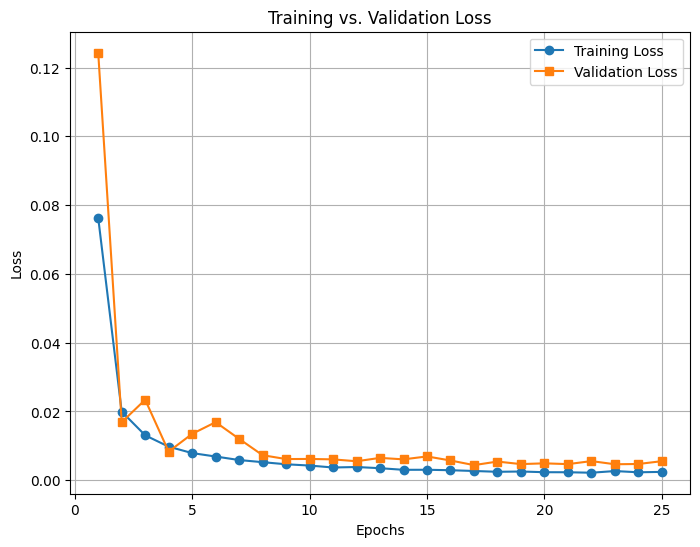

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load test dataset
h5_test_path = "/content/final_datasets/test_extra_TRM_DLY.h5"
csv_test_path = "/content/final_datasets/test_extra_TRM_DLY.csv"

model_load_path = "/content/drive/MyDrive/Capstone 210/Models/final_multi_effects_alt9.mod"

test_dataset = SpectrogramDataset(h5_test_path, csv_test_path)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)

num_classes = len(test_dataset.label_map)

# Load a saved model for test dataset metrics
model = spectrogramCNN(num_classes).to(device)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()
print("Model loaded successfully.")

print("\nEvaluating with external test dataset...")

model.eval()
criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for spectrograms, labels in test_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert logits to binary predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)

# Compute test metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="macro", zero_division=0)
test_recall = recall_score(test_labels, test_preds, average="macro", zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print(f"\nTest Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

# Print classification report
class_names = test_dataset.label_map
print(classification_report(test_labels, test_preds, target_names=class_names))

<ipython-input-7-c3455c24d392>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Model loaded successfully.

Evaluating with external test dataset...

Test Loss: 0.0050, Accuracy: 0.9835, Precision: 0.9936, Recall: 0.9932, F1-score: 0.9934

              precision    recall  f1-score   support

   overdrive       1.00      0.99      1.00      3028
  distortion       1.00      0.99      1.00      4544
        fuzz       1.00      1.00      1.00      5300
     tremolo       1.00      1.00      1.00      4542
      phaser       1.00      1.00      1.00      4542
     flanger       1.00      0.99      0.99      3028
      chorus       1.00      1.00      1.00      5300
       delay       0.99      1.00      0.99      8328
 hall_reverb       0.97      0.98      0.98      3788
plate_reverb       0.98      0.99      0.99      3028
     octaver       0.99      0.99      0.99      2271
 auto_filter       1.00      0.99      1.00      3785

   micro avg       0.99      0.99      0.99     51484
   macro avg       0.99      0.99      0.99     51484
weighted avg       0.99     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load test dataset
# h5_test_path = "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.h5"
# csv_test_path = "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.csv"

h5_test_path = "/content/final_datasets/final_real.h5"
csv_test_path = "/content/final_datasets/final_real.csv"

model_load_path = "/content/drive/MyDrive/Capstone 210/Models/final_multi_effects_alt9.mod"

test_dataset = SpectrogramDataset(h5_test_path, csv_test_path)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)

num_classes = len(test_dataset.label_map)

# Load a saved model for test dataset metrics
model = spectrogramCNN(num_classes).to(device)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()
print("Model loaded successfully.")

print("\nEvaluating with external test dataset...")

model.eval()
criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for spectrograms, labels in test_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert logits to binary predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)

# Compute test metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="macro", zero_division=0)
test_recall = recall_score(test_labels, test_preds, average="macro", zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print(f"\nTest Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

# Print classification report
class_names = test_dataset.label_map
print(classification_report(test_labels, test_preds, target_names=class_names))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-5-a87bdd7aeb2c>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

Model loaded successfully.

Evaluating with external test dataset...

Test Loss: 0.0951, Accuracy: 0.7859, Precision: 0.9025, Recall: 0.9216, F1-score: 0.9048

              precision    recall  f1-score   support

   overdrive       0.84      0.79      0.81      3432
  distortion       0.99      0.97      0.98      5148
        fuzz       0.99      0.96      0.97      6006
     tremolo       0.87      0.99      0.92      4290
      phaser       0.99      0.96      0.98      5148
     flanger       0.99      0.73      0.84      3432
      chorus       0.95      0.95      0.95      6006
       delay       0.93      0.93      0.93      7722
 hall_reverb       0.89      0.98      0.93      5148
plate_reverb       0.96      0.87      0.91      3432
     octaver       0.57      0.99      0.73      2574
 auto_filter       0.87      0.94      0.90      4290

   micro avg       0.91      0.93      0.92     56628
   macro avg       0.90      0.92      0.90     56628
weighted avg       0.92     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from google.colab import runtime
runtime.unassign()